# MIT JLab Project: Detect GW with LIGO open data
Author: Jing Wang , Eric Moreno <br>
Date: Sep 29 2020 (Updated December 2021) 

* This tutorial is developed for MIT Junior lab project "Detect GW with LIGO open data".
* A manual of this project can be found [here](http://www.mit.edu/~jwang011/LIGOmanualJLab.pdf).
* This tutorial is based on the material on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/) and the tutorial from Professor Philip Harris.
* Some codes are hidden, and you need to build it by yourself.
* <span style="color:#CF7A17;font-weight:bold">Orange bold text</span> hightlights the questions you need to answer or codes you need to develop.

## Introduction
The existence of gravitational waves (GW) was first predicted by Albert Einstein in his General Theory of Relativity in 1916.
He found that the linearized weak-field equations had wave solutions.
By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain.
The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract).
However, direct detections of GW did not arrive until 2016.
In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102).
The observations reported in this paper and futher GW detections would provide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. This tutorial will show how to analyze a particular GW event GW150914. In the tutorial, you will find how to download the data collected by Handford Observatory starting from Mon Sep 14 09:16:37 GMT 2015, plot the strain, whiten and filter the strain, plot a q-transform of the data, and extract the features of the source with a simple analytic model. After getting familiar with the basic analysis methods, you need to explore more events, check the consistence between detectors, match numerical relativity waveform template to extract accurate information of the source, compare with LIGO published results, and develop a machinery to search GW event within a long time range.

## Preparation

### Install dependencies

In [2]:
#----------------------------------------------------------------
# pip install libraries
#----------------------------------------------------------------
!pip install gwpy numpy scipy matplotlib h5py wget

### Download the data

In [3]:
import wget
import os

os.mkdir('data')
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'data')

'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'

All the available open data can be found on [Gravitational Wave Open Science Center](https://www.gw-openscience.org/eventapi/html/allevents/). In this tutorial, we take event GW150914 data as example. In the name of this particular data file:
  * "GW150914" means September 14, 2015 
  * "H-H1" means that the data come from the LIGO Hanford Observatory site and the LIGO "H1" datector;
  * "1126257414-4096" means the data starts at GPS time 1126257414 (Mon Sep 14 09:16:37 GMT 2015), duration 4096 seconds;
    * NOTE: GPS time is number of seconds since Jan 6, 1980 GMT. See http://www.oc.nps.edu/oc2902w/gps/timsys.html.

### Load libraries

In [4]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries
from scipy.linalg import fractional_matrix_power
from scipy.stats import zscore

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline

### Set input file and parameters

In [5]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1

### Load data

In [6]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

## Analysis on a known event

### First look at data: raw time-series data

<Figure size 432x288 with 0 Axes>

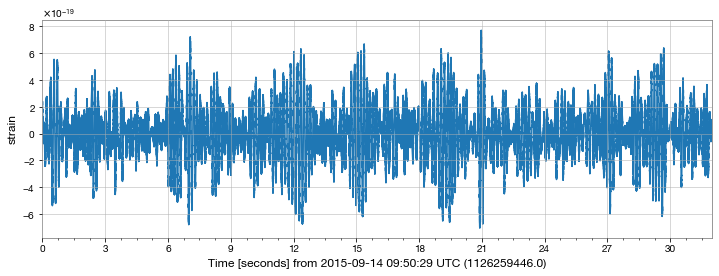

In [7]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

The data are dominated by low frequency noise, and there is no way to see a signal here.

### Data in the Fourier domain: ASDs

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD. The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data. They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

<Figure size 432x288 with 0 Axes>

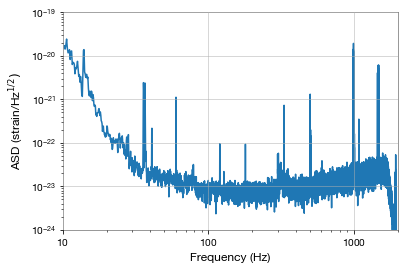

In [8]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()


You can see strong spectral lines in the data. They are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

You can't see the signal in this plot, since it is relatively weak and less than a second long, while this plot averages over 32 seconds of data. So this plot is entirely dominated by instrumental noise.

### Whitening data
From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. We can "whiten" the data, suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band. This is done by normalizing the power at all frequencies so that excess power at any frequency is more obvious. The whitening transformation is well explained [here](https://courses.media.mit.edu/2010fall/mas622j/whiten.pdf). Below, a rough whitener is implemented, but the [GWPy whitener](https://github.com/gwpy/gwpy/blob/master/gwpy/timeseries/timeseries.py#L1657-L1752) does some additional fancy time-series operations.


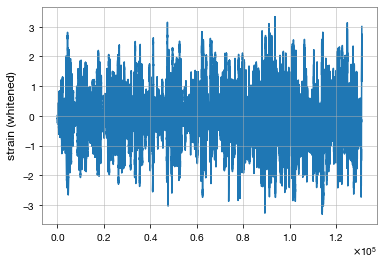

In [9]:
#----------------------------------------------------------------
# Whitening implemented by-hand
#----------------------------------------------------------------

def rough_whitener(strain_data, filter_length): 
    zscored = zscore(np.array(strain_data))
    cov = np.cov(zscored.reshape(-1, filter_length*4096))
    eigval, eigvec = np.linalg.eig(cov)
    whitened = np.matmul(np.matmul(fractional_matrix_power(np.diag(eigval), -1/2), np.transpose(eigvec)), zscored.reshape(-1, filter_length*4096))
    return(whitened.reshape(-1))

plt.clf()
plt.plot(rough_whitener(strain, 2))
plt.ylabel('strain (whitened)')
plt.show()

<Figure size 432x288 with 0 Axes>

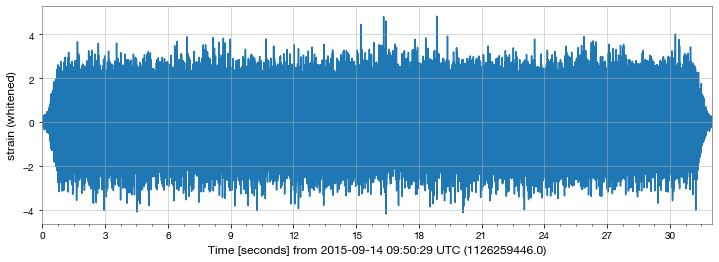

In [10]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten() #We will just use the GWpy whitening function here

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

We seem to see potential signal now... (maybe?) It's still not good enought, next we will apply a band-pass filter to reject high frequency noise.

### Bandpassing filter
A bandpass filter can select data from a specific range of frequencies and is used in a wide variety of physics applications. The macro below shows you a framework to do bandpanssing within gwpy. This will select data with frequencies above bandpass_low and below bandpass_high. <br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: play with the filter thresholds (bandpass_low and bandpass_high), and find a window leading to a clear signal on the upper plot. On the lower plot, check out how this bandpass filter affects the ASD and compare to the original ASD plot! </span>


In [1]:
print('# [Hidden code] Here set:')
print('bandpass_low = ')
print('bandpass_high = ')

bandpass_low = 70
bandpass_high = 400

# [Hidden code] Here set:
bandpass_low = 
bandpass_high = 


<Figure size 432x288 with 0 Axes>

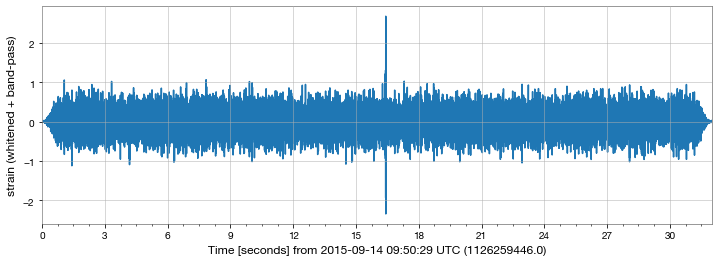

<Figure size 432x288 with 0 Axes>

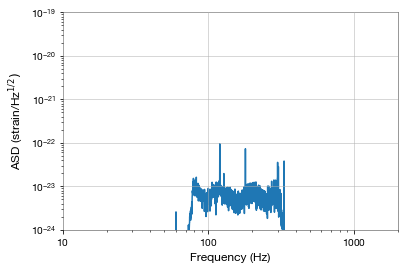

In [45]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

strain_bandpass = strain.bandpass(bandpass_low, bandpass_high) #Note: for the sake of comparison, we are using unwhitened strain
asd = strain_bandpass.asd(fftlength=8)
plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

With the proper bandpass_low and bandpass_high set, we see a significant signal! Next let's zoom in it.

<Figure size 432x288 with 0 Axes>

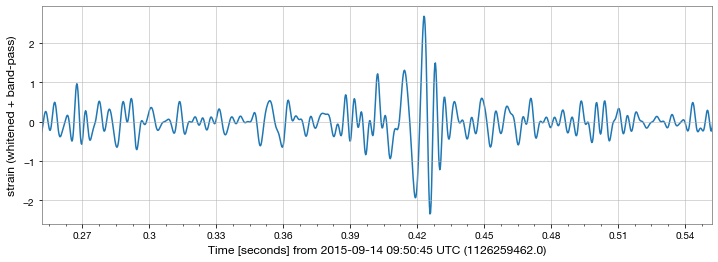

In [46]:
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

We see wave shape!! This is GW signal.

### Plot a q-transform of the data
Next we take a q-transform of the data and check the time variation of frequency. This q-transform is formed by taking the magnitude of the [Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), normally on a log-intensity axis (e.g. Energy).

<Figure size 432x288 with 0 Axes>

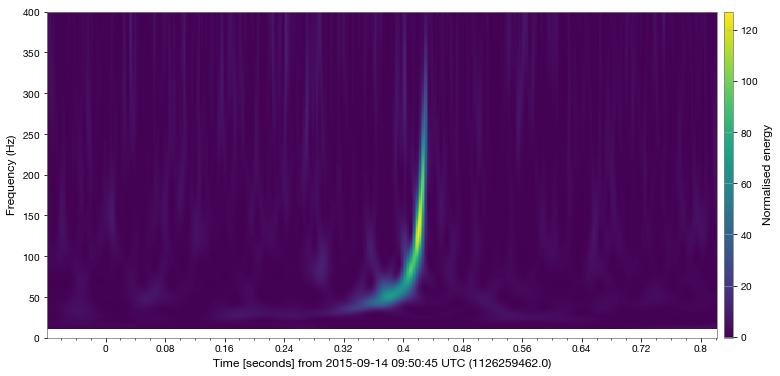

In [34]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

The yellow line is signal. Next we try developing an analytic model to describe this.

In [13]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Analytic model: frequency vs. time
Calculating the actual waveform requires complicated numerical simulations. However, we can use the basic knowledge of General Relativity (GR) and Newtonian mechanics to perform an approximate analytic calculation for the waveform. For an orbiting binary system ($m_{1}$ and $m_{2}$), according to GR the frequency ($\omega(t)$) of the GW radiation satisfies
\begin{equation}
\dot{\omega} = \frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}\omega^{\frac{11}{3}}
\label{eq:wwdot}
\end{equation}
where $G$ and $c$ are gravitational constant and the speed of light respectively. $\mathcal{M}_{c}$ is so-called chirp mass, defined by
\begin{equation}
\mathcal{M}_{c} = \frac{(m_{1}m_{2})^{\frac{3}{5}}}{(m_{1}+{m_{2}})^{\frac{1}{5}}}
\label{eq:Mc}
\end{equation}
Integrating Eq.\eqref{eq:wwdot}, we can get
\begin{eqnarray}
\int\omega^{-\frac{11}{3}}d\omega &= \int\frac{12}{5}2^{\frac{1}{3}}\left(\frac{G\mathcal{M}_{c}}{c^{3}}\right)^{\frac{5}{3}}dt \\
    \Rightarrow \omega(t) &= \frac{5^{\frac{3}{8}}}{4}\left(\frac{c^{3}}{G\mathcal{M}_{c}}\right)^{\frac{5}{8}}\Delta t^{-\frac{3}{8}} \\
\end{eqnarray}
Now we get the time dependence of frequency. Considering
\begin{equation}\label{eq:msolar}
  \frac{GM_{\odot}}{c^{3}} \approx 4.93~\mathrm{\mu s}
\end{equation}
We have
\begin{equation}\label{eq:wtnum}
  \omega(t) = 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]}
\end{equation}
Now let's plot this function and see how it looks like.

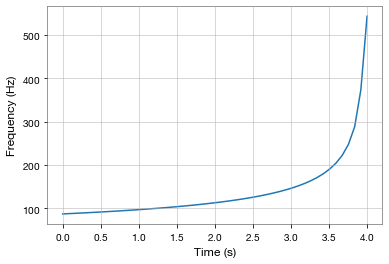

In [47]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

The shape is very similar to what we have seen in data. You can use the model to fit data as play, and we don't do it here. Next, we try building the analytic model of wave form.

### Analytic model: Wave form
Now, we build the waveform with the radiation power $dE(t)/dt$.
\begin{eqnarray}
f(t) &= A(t)\cos(\omega(t)\Delta t +\phi) \\
\label{eq:ft}    &\propto \frac{dE(t)}{dt}\cos(\omega(t)\Delta t +\phi) \\
\end{eqnarray}
With Newtonian mechanics, we know the energy of a binary orbit is
\begin{eqnarray}
E &= E_{\mathrm{k}} + E_{\mathrm{u}} \\
    &= \frac{1}{2}\mu\dot{r}^{2} + \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\
\label{eq:Etot}    &= \frac{1}{2}\frac{m_{1}m_{2}}{m_{1}+m_{2}}\omega^{2}R^{2} - \frac{Gm_{1}m_{2}}{R} \\ 
\end{eqnarray}
The last step is because $\dot{r} = 0$. According to Kepler's third law,
\begin{equation}\label{eq:kepler}
  \omega^{2} = \frac{G(m_{1}+m_{2})}{R^{3}}
\end{equation}
Put \eqref{eq:kepler} into \eqref{eq:Etot} and substitute $R$, we have
\begin{eqnarray}
E &= -\frac{Gm_{1}m_{2}}{2R} \\
\label{eq:Ew}    &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{\frac{2}{3}} \\
\end{eqnarray}
Perform derivatives on Eq.\eqref{eq:Ew},
\begin{eqnarray}
\frac{dE}{dt} &\propto \mathcal{M}_{c}^{\frac{5}{3}}\omega(t)^{-\frac{1}{3}}\dot{\omega} \\
\label{eq:dEdt}    &\propto \left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}} \\
\end{eqnarray}
Put Eq.\eqref{eq:dEdt} into Eq.~\eqref{eq:ft}, we have the waveform
\begin{eqnarray}
\label{eq:fwt}
f(t) &= C\left(\mathcal{M}_{c}\omega(t)\right)^{\frac{10}{3}}\cos(\omega(t)\Delta t +\phi), \\
    \mathrm{where}\:\omega(t) &= 948.5\left(\frac{M_{\odot}}{\mathcal{M}_{c}}\right)^{\frac{5}{8}}\left(\frac{1\:\mathrm{s}}{\Delta t}\right)^{\frac{3}{8}}\;\mathrm{[Hz\cdot rad]} \\
\end{eqnarray}
and $C$ is a constant. This waveform amplitude is only supposed to work before merger ($t \leq t_{0}$), and we need to come up with a way to define the ringdown amplitude ($t > t_{0}$). The actual way to get the amplitude requires months of a super computer to build good templates. As a simple approximate solution, you can use a simple damping function (Here I use an exponential).<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: Build a function osc(t, Mc, t0, C, phi). It has the form as Eq.\eqref{eq:fwt} for $t \leq t_{0}$, but damp to vanish for $t > t_{0}$.</span>

In [41]:
print('# [Hidden code]: Define the model function w(t) here.')
print('def osc(t, Mc, t0, C, phi):')

def osc(t, Mc, t0, C, phi):
    
    w = gwfreq(Mc, t, t0)
    before = C * np.power(Mc*w, 10./3.) * np.cos(w*(t-t0)+phi)
    b = 80
    w0 = gwfreq(Mc, t0, t0)
    after = C * np.power(Mc*w, 10./3.) * np.exp(-b*(t-t0)) * np.cos(w0*(t-t0)+phi)
    
    return np.where(t<t0, before, after)

# [Hidden code]: Define the model function w(t) here.
def osc(t, Mc, t0, C, phi):


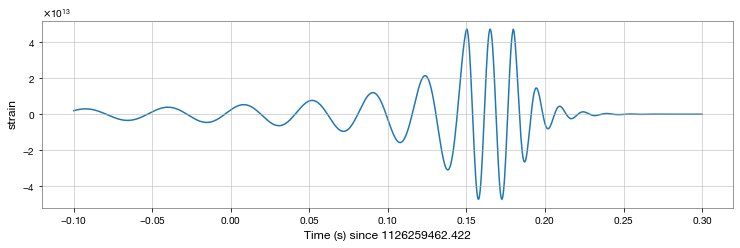

In [48]:
# Draw the function defined
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()

Looks not bad. Now we use this function to fit the data.

In [38]:
# define osc_dif for lmfit::minimize()
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 491
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.50737764
    reduced chi-square = 4.1452e-04
    Akaike info crit   = -9560.13615
    Bayesian info crit = -9539.68358
[[Variables]]
    Mc:   16.3257401 +/- 0.26823946 (1.64%) (init = 23)
    t0:   0.17065435 +/- 8.3964e-04 (0.49%) (init = 0.18)
    C:   -2.5329e-14 +/- 1.7986e-15 (7.10%) (init = 1)
    phi: -3.53031319 +/- 0.56123057 (15.90%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = 0.982
    C(Mc, phi) = -0.893
    C(Mc, t0)  = -0.828
    C(Mc, C)   = 0.245
    C(C, phi)  = -0.203
    C(t0, C)   = -0.184


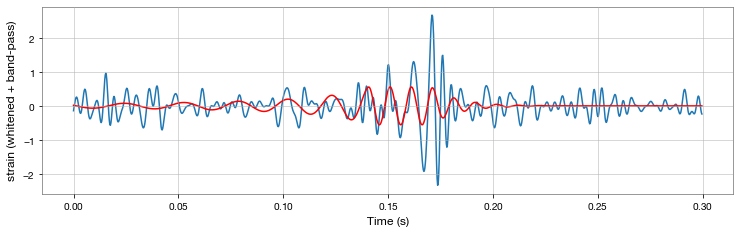

In [49]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(23)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

With the simple analytic model, we actually caught the wave shape for $t<t_{0}$. The parameter gives the value $\mathcal{M}_{c}/M_{\odot}\sim 17$. The actual mass is $\sim 28$ (not too far!)

## Search signal in long time range
When we zoom in the data above, we look at the small range where the signal is. However in reality we don't know where the signal is in advance.<br>
<span style="color:#CF7A17;font-weight:bold">What you need to do: develop a machinery to search for GW events across a long time range</span>.<br>
Tip: You can slice the time into short ranges, and fit by one and see the significance.

In [19]:
print('# [Hidden code]: develop a machinery to search for GW events across a long time range.')
#----------------------------------------------------------------
# Significance vs. time
#----------------------------------------------------------------


# [Hidden code]: develop a machinery to search for GW events across a long time range.


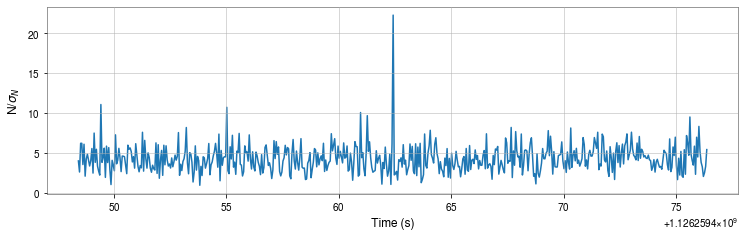

In [20]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, sigs)
plt.xlabel('Time (s)')
plt.ylabel('N/$\sigma_{N}$')
plt.show()

We can see the significance is significantly higher around the signal event. We can also check the $\chi^{2}$.

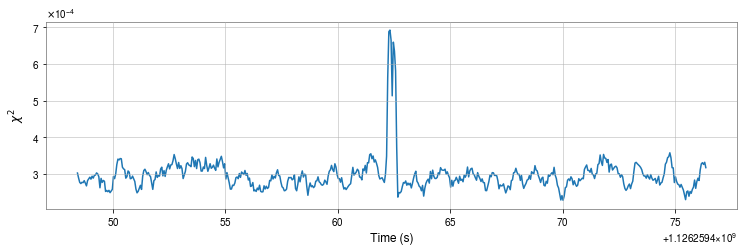

In [21]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, chi2)
plt.xlabel('Time (s)')
plt.ylabel('$\chi^{2}$')
plt.show()

## More things to explore
Now you have known the basic method to analyze a particular GW event. Now you can explore more interesting things.<br>
  * <span style="color:#CF7A17;font-weight:bold">Check and quantify the correlation and time delay between detectors (below);</span>
  * <span style="color:#CF7A17;font-weight:bold">Load the template database, fit the data, and get more accurate parameters (MIT_8.S50/Project1/extra/GW_PEInjection_tutorial.ipynb);</span>
  * <span style="color:#CF7A17;font-weight:bold">Determine how far the source of GW is away;</span>
  * <span style="color:#CF7A17;font-weight:bold">Explore more events;</span>
    * <span style="color:#CF7A17;font-weight:bold">Data of other events can be found [here](https://www.gw-openscience.org/eventapi/html/allevents/).</span>
  * <span style="color:#CF7A17;font-weight:bold">How to determine if the source is black hole merger or neutron star merger or other source?</span>

**Have fun!**

## Optional - Exploring Correlation and Time-Delay between detectors

Next, we can try to analyze data through multiple detector streams. Recall that LIGO employs various detectors (Hanford-H1, Livingston-L1, Virgo-V1) to decrease their false positive rate and identify the region in the sky where the GW arrives from. This can be useful to alert the multimessenger astronomy community of an interesting event - think when Binary Neutron Star (BNS) merger GW-170817 was successfully detected by LIGO and allowed observatories in various EM-wavelengths to point their telescopes at the event, allowing for experimental evidence of the creation of heavy-metals whose origin was previously a mystery. Since detectors are located thousands of miles from each other, the only seemingly correlated signal between each should be a GW.

In this section, we will correlate the signals from H1, L1, and V1 from [GW200129_065458](https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1). First, read in the data and perform the normal bandpassing and whitening: 

In [22]:
#----------------------------------------------------------------
# Download data
#----------------------------------------------------------------

wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/H-H1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'data')
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/L-L1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'data')
wget.download('https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200129_065458/v1/V-V1_GWOSC_4KHZ_R1-1264314069-4096.hdf5', 'data')

'data/V-V1_GWOSC_4KHZ_R1-1264314069-4096.hdf5'

In [23]:
#----------------------------------------------------------------
# Read in data
#----------------------------------------------------------------

fn_H1 = 'data/H-H1_GWOSC_4KHZ_R1-1264314069-4096.hdf5' # data file
fn_L1 = 'data/L-L1_GWOSC_4KHZ_R1-1264314069-4096.hdf5' # data file
fn_V1 = 'data/V-V1_GWOSC_4KHZ_R1-1264314069-4096.hdf5'
tevent = 1264316116.4 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW200129_065458' # event name

strain_H1 = TimeSeries.read(fn_H1, format='hdf5.losc')
strain_L1 = TimeSeries.read(fn_L1, format='hdf5.losc')
strain_V1 = TimeSeries.read(fn_V1, format='hdf5.losc')
center = int(tevent)
strain_H1 = strain_H1.crop(center-16, center+16)
strain_L1 = strain_L1.crop(center-16, center+16)
strain_V1 = strain_V1.crop(center-16, center+16)

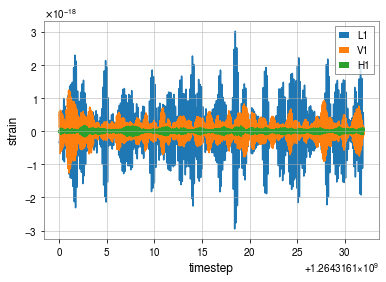

In [24]:
#----------------------------------------------------------------
# Compare strains
#----------------------------------------------------------------

plt.figure()
plt.plot(strain_L1, label='L1')
plt.plot(strain_V1, label='V1')
plt.plot(strain_H1, label='H1')

plt.legend()
plt.ylabel('strain')
plt.xlabel('timestep')
plt.show()

As we can see, the strain magnitudes look very different between all three detectors! It's almost impossible to build three perfectly identical detectors thousands of miles from each other. However, we can still correlated signals between them. Lets continue our normal preprocessing techniques: whitening and bandpass. As we can see in the bottom plot, there is a noticable difference between the L1 and H1 streams. 

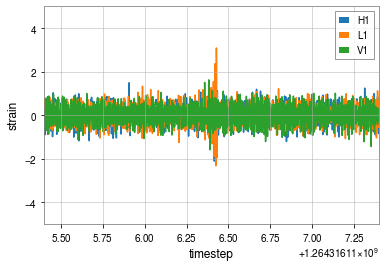

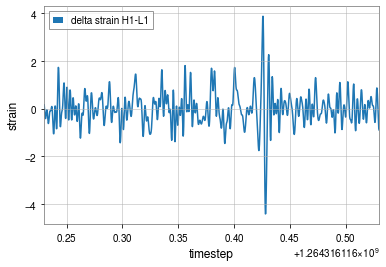

In [25]:
#----------------------------------------------------------------
# Preprocess data
#----------------------------------------------------------------

# Remember you defined bandpass_low and bandpass_high above 

white_data_H1 = strain_H1.whiten()
white_data_L1 = strain_L1.whiten()
white_data_V1 = strain_V1.whiten()
white_data_H1_bp = white_data_H1.bandpass(bandpass_low, bandpass_high) 
white_data_L1_bp = white_data_L1.bandpass(bandpass_low, bandpass_high)
white_data_V1_bp = white_data_V1.bandpass(bandpass_low, bandpass_high)

# Side note: These bandpass frequencies are okay for high mass black hole mergers (like the ones analyzed here), but smaller mass 
# mergers like neutron stars can arrive at frequencies up to 2 KHz! 

plt.figure()
plt.plot(white_data_H1_bp, label='H1')
plt.plot(white_data_L1_bp, label='L1')
plt.plot(white_data_V1_bp, label='V1')

plt.legend()
plt.ylabel('strain')
plt.xlabel('timestep')
plt.ylim(-5, 5)
plt.xlim(tevent-1, tevent+1)
plt.show()

plt.figure()
delta = white_data_H1_bp - white_data_L1_bp
plt.plot(delta, label='delta strain H1-L1')
plt.legend(loc='upper left')
plt.ylabel('strain')
plt.xlabel('timestep')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

Now we can correlate signals across the multiple detectors. Correlation is done by detrending the input and compared detector strain and then outputting normalized SNRs as number of standard deviations from the expected mean. NOTE: this is a correlation test that LIGO uses to announce GW detections by comparing datastreams to GW-templates (matched-filtering) but we are using it for a bit of a different reason. 

<span style="color:#CF7A17;font-weight:bold">What you need to do: develop a machinery to correlate signals between detectors with the gwpy.TimeSeries.correlate() function. This will give you an SNR (try plotting it!) which you can then use to find the offset signal between detectors. 

# [Hidden code]: develop a function offset(detector1_strain, detector2_strain) which returns the number of steps and time which two strains are offset


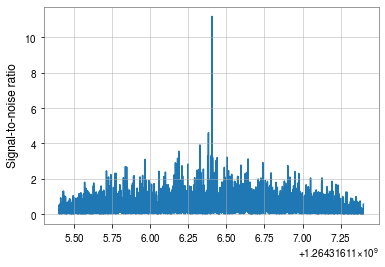

Number of steps shifted from H1 to L1: 21
Time shifted from H1 to L1: 0.005126953125 s


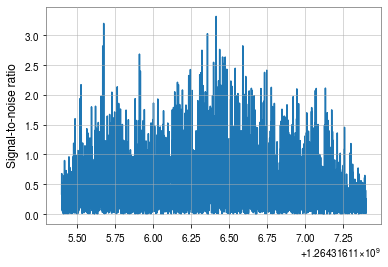

Number of steps shifted from H1 to V1: 63
Time shifted from V1 to H1: 0.015380859375 s


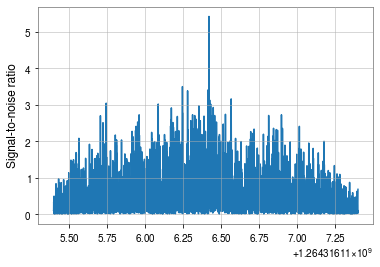

Number of steps shifted from V1 to L1: 86
Time shifted from V1 to L1: 0.02099609375 s


In [26]:
#----------------------------------------------------------------
# Calculate offset between detectors
#----------------------------------------------------------------

print('# [Hidden code]: develop a function offset(detector1_strain, detector2_strain) which returns the number of steps and time which two strains are offset')

def offset(detector1, detector2):
    
    '''define code here'''
    
    return(shiftSteps, shiftTime)


shiftStepsH1L1, shiftTimeH1L1 = offset(white_data_L1_bp, white_data_H1_bp)
print('Number of steps shifted from H1 to L1: %s'%(str(shiftStepsH1L1)))
print('Time shifted from H1 to L1: %s'%str(shiftTimeH1L1))

shiftStepsH1V1, shiftTimeH1V1 = offset(white_data_H1_bp, white_data_V1_bp)
print('Number of steps shifted from H1 to V1: %s'%str(shiftStepsH1V1))
print('Time shifted from V1 to H1: %s'%str(shiftTimeH1V1))

shiftStepsL1V1, shiftTimeL1V1 = offset(white_data_L1_bp, white_data_V1_bp)
print('Number of steps shifted from V1 to L1: %s'%str(shiftStepsL1V1))
print('Time shifted from V1 to L1: %s'%str(shiftTimeL1V1))


Next, plot the shifted strain against the other strains. You should see that the strains are now overlapping.

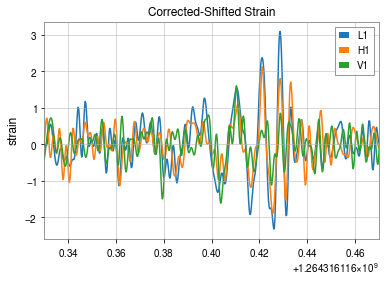

In [27]:
#----------------------------------------------------------------
# Shift detector strains
#----------------------------------------------------------------


# The timeseries.shift(delta) function will simply shift the X-axis (time) forward by the specified delta
shifted_data_H1 = white_data_H1_bp.copy()
shifted_data_H1.shift(shiftTimeH1L1)
shifted_data_H1 *= -1 

shifted_data_V1 = white_data_V1_bp.copy()
shifted_data_V1.shift(shiftTimeL1V1)
shifted_data_V1 *= -1

plt.figure()
plt.plot(white_data_L1_bp, label='L1')
plt.plot(shifted_data_H1, label='H1')
plt.plot(shifted_data_V1, label='V1')
plt.legend()
plt.ylabel('strain')
plt.xlim(tevent-0.07, tevent+0.07)
plt.title('Corrected-Shifted Strain')
plt.show()

It looks like the strains are aligning well! Next, we can calculate the region in the sky where this GW resides given the offsets between detectors. Think of the GW as some farfield source whose wave creates a right triangle between two detectors. This will give you a region in space where 

<span style="color:#CF7A17;font-weight:bold">What you need to do: Calculate the projected angles in the direction of:
   * <span style="color:#CF7A17;font-weight:bold"> L1 to H1 (3000 km) </span>
   * <span style="color:#CF7A17;font-weight:bold"> H1 to V1 (8166 km) </span>
   * <span style="color:#CF7A17;font-weight:bold"> L1 to V1 (8868 km) </span>
    

In [29]:
#----------------------------------------------------------------
# Calculate angle in sky
#----------------------------------------------------------------

print('# [Hidden code]: Calculate (using simple trigonometry) the cone where the GW resides in the sky for each detector pair')

DistanceL1H1 = 3000 #km
DistanceH1V1 = 8166 #km
DistanceL1V1 = 8868 #km
c = 3e5 # Speed of light in Km/s

AngleL1H1 = 
AngleH1V1 = 
AngleL1V1 = 

print('Angle in sky from L1 towards H1: %s degrees'%(AngleL1H1))
print('Angle in sky from H1 towards V1: %s degrees'%(AngleH1V1))
print('Angle in sky from L1 towards V1: %s degrees'%(AngleL1V1))

# The geometry that projects these angles onto skymaps isn't particularly enlightening so I will just provide some premade skymaps of the event

from IPython.display import Image
display(Image(url='https://data.cardiffgravity.org/gwcat-data/data/png/GW200129_065458_moll.png'))
display(Image(url='https://data.cardiffgravity.org/gwcat-data/data/png/GW200129_065458_moll_pretty.png'))

# [Hidden code]: Calculate (using simple trigonometry) the cone where the GW resides in the sky for each detector pair
Angle in sky from L1 towards H1: 59.156469485387305 degrees
Angle in sky from H1 towards V1: 55.593730426484825 degrees
Angle in sky from L1 towards V1: 44.74170114551119 degrees
